In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
!pip install opendatasets

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
    activations
)

from scipy.stats import norm
import pandas as pd
import os
import json
import re
import string
import math

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import opendatasets as od
import numpy as np

In [ ]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 5

In [ ]:
path = 'https://www.kaggle.com/datasets/zynicide/wine-reviews'
od.download(path,data_dir='./data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gauravpurwar12
Your Kaggle Key: ··········


100%|██████████| 50.9M/50.9M [00:01<00:00, 28.1MB/s]


In [ ]:
with open('/content/data/wine-reviews/winemag-data-130k-v2.json') as json_data:
  wine_data = json.load(json_data)

In [ ]:
filtered_data = [
    "wine review : "
    + x['country']
    + " : "
    + x['province']
    + " : "
    + x['variety']
    + " : "
    + x['description']
    for x in wine_data
    if x['country'] is not None
    and x['province'] is not None
    and x['variety'] is not None
    and x['description'] is not None
  ]

In [ ]:
example = filtered_data[25]
print(example)

wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.


In [ ]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


In [ ]:
text_data = [pad_punctuation(x) for x in filtered_data]

In [ ]:
text_ds = tf.data.Dataset.from_tensor_slices(text_data).batch(BATCH_SIZE).shuffle(1000)

In [ ]:
vectorize_layer = layers.TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = 'lower',
    output_mode = 'int',
    output_sequence_length = MAX_LEN + 1
)

In [ ]:
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
for i, word in enumerate(vocab[:20]):
  print(f'{i}: {word}' )

0: 
1: [UNK]
2: :
3: ,
4: .
5: and
6: the
7: wine
8: a
9: of
10: review
11: with
12: this
13: is
14: -
15: it
16: flavors
17: in
18: '
19: to


In [ ]:
example_tokernised = vectorize_layer(example)
print(example_tokernised.numpy())

[   7   10    2   20    2   29    2   43   62    2   55    5  243 4145
  453  634   26    9  497  499  667   17   12    1   43   25 2484   32
    8    1    1  594   17    1   15   75    1    1   97    5   74 2633
   17  198   49    5  125    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
def prepare_input(text):
  text = tf.expand_dims(text,-1)
  tokenized_sentence = vectorize_layer(text)
  x = tokenized_sentence[:,:-1]
  y = tokenized_sentence[:,1:]
  return x,y

In [ ]:
training_ds= text_ds.map(prepare_input)

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [ ]:
class TransformerBlock(layers.Layer):
  def __init__(self,num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
     super(TransformerBlock, self).__init__()
     self.num_heads = num_heads
     self.key_dim = key_dim
     self.embed_dim = embed_dim
     self.ff_dim = ff_dim
     self.dropout_rate = dropout_rate
     self.att = layers.MultiHeadAttention(num_heads, key_dim, output_shape=embed_dim)
     self.dropout_1 = layers.Dropout(self.dropout_rate)
     self.dropout_2 = layers.Dropout(self.dropout_rate)
     self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
     self.ln_2 = layers.LayerNormalization(epsilon=1e-6)
     self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
     self.ffn_2 = layers.Dense(self.embed_dim)

  def call(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size = input_shape[0]
    seq_len = input_shape[1]
    casual_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

    attention_output, attention_scores = self.att(inputs, inputs, attention_mask = casual_mask, return_attention_scores=True)
    attention_output = self.dropout_1(attention_output)
    out1 = self.ln_1(attention_output + inputs)
    ffn_1 = self.ffn_1(out1)
    ffn_2 = self.ffn_2(ffn_1)
    ffn_output = self.dropout_2(ffn_2)
    out = self.ln_2(out1 + ffn_2)
    return out, attention_scores

  def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [ ]:
class TextAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size,embed_dim):
     super(TextAndPositionEmbedding, self).__init__()

     self.maxlen = maxlen
     self.vocab_size = vocab_size
     self.embed_dim = embed_dim
     self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
     self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self,x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return (x + positions)

  def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.maxlen,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config




In [ ]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TextAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores  = TransformerBlock(N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x)
output = layers.Dense(VOCAB_SIZE, activation='softmax')(x)
gpt = models.Model(inputs=inputs, outputs=[output, attention_scores])
gpt.compile('adam', loss=[losses.SparseCategoricalCrossentropy(), None])
gpt.summary()
#gpt.fit(training_ds, EPOCHS)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 text_and_position_embeddin  (None, None, 256)         2580480   
 g_3 (TextAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block_3 (Trans  ((None, None, 256),       658688    
 formerBlock)                 (None, 2, None, None))             
                                                                 
 dense_11 (Dense)            (None, None, 10000)       2570000   
                                                                 
Total params: 5809168 (22.16 MB)
Trainable params: 5809168 (22.16 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

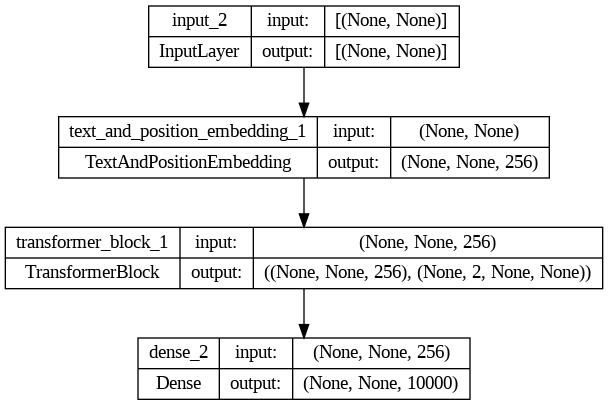

In [ ]:
tf.keras.utils.plot_model(gpt, to_file='dot_img_file.png', show_shapes=True)

In [ ]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", max_tokens=80, temperature=1.0)

In [ ]:
model_checkpoint_callbacks = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')

text_generator = TextGenerator(vocab)

In [ ]:
gpt.fit(training_ds, epochs= EPOCHS, callbacks=[model_checkpoint_callbacks,tensorboard_callback, text_generator])

Epoch 1/5
4059/4060 [============================>.] - ETA: 0s - loss: 2.2449 - dense_11_loss: 2.2449
generated text:
wine review : us : california : grenache : [UNK] ' s most attractive perennial rochioli pinot noir , pinot noir , but it starts with thin aromas and flavors that earthy and slightly bitter . 

4060/4060 [==============================] - 165s 39ms/step - loss: 2.2450 - dense_11_loss: 2.2450
Epoch 2/5
4059/4060 [============================>.] - ETA: 0s - loss: 1.9501 - dense_11_loss: 1.9501
generated text:
wine review : france : languedoc - roussillon : rhône - style red blend : a blend made from 60 % grenache , 35 % carignan , 20 % mourvèdre , 20 % syrah , 5 % carignan and 3 % mourvèdre , this offers bright red berry aromas along with savory notes shaded by meld black cherry , mocha and ripe plum . medium tannins feel concentrated and fruit cut through the expressive finish . 

4060/4060 [==============================] - 129s 32ms/step - loss: 1.9501 - dense_11_loss: 

In [ ]:
gpt.save('./model/gpt')

In [ ]:
os.makedirs('./model/gpt')

In [ ]:
info = text_generator.generate('wine review : us :', max_tokens=80, temperature=1.0)


generated text:
wine review : us : california : malbec : mike sinor [UNK] , [UNK] attention makes this eye - opener for a rising - top example of the vineyard shiraz . it ' s an explosion of plush , plush , ripe plum and blackberry , with black pepper , anise , [UNK] fruit and molasses all accentuated by the vineyard ' s varietal influence . it ' s well integrated on its own , with an intense touch of



In [ ]:
info = text_generator.generate(
    "wine review : italy", max_tokens=80, temperature=0.5
)


generated text:
wine review : italy : veneto : glera : a little shy on the nose , the palate offers bartlett pear , white pepper and a hint of white pepper alongside crisp acidity and a hint of bitter almond . 



In [ ]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [ ]:
info = text_generator.generate(
    "wine review : germany", max_tokens=80, temperature=0.5
)
print_probs(info, vocab)


generated text:
wine review : germany : mosel : riesling : ripe yellow peaches perfume this bright , juicy , fruity riesling . it ' s juicy and fruity , with a touch of sweetness , but it ' s a shade off - dry , but with a long , citrusy finish . 



::   	100.0%
-:   	0.0%
zealand:   	0.0%
[UNK]:   	0.0%
blanc:   	0.0%
--------



mosel:   	66.98%
pfalz:   	16.48%
rheingau:   	14.07%
nahe:   	1.13%
rheinhessen:   	1.06%
--------



::   	99.55%
-:   	0.45%
in:   	0.0%
.:   	0.0%
to:   	0.0%
--------



riesling:   	99.99%
pinot:   	0.01%
weissburgunder:   	0.0%
sparkling:   	0.0%
spätburgunder:   	0.0%
--------



::   	100.0%
-:   	0.0%
blend:   	0.0%
,:   	0.0%
.:   	0.0%
--------



a:   	38.07%
while:   	12.19%
this:   	9.8%
whiffs:   	9.44%
fresh:   	5.37%
--------



,:   	31.79%
yellow:   	23.6%
and:   	13.86%
peach:   	11.53%
apple:   	7.15%
--------



peaches:   	30.91%
peach:   	28.7%
plum:   	22.38%
-:   	7.35%
cherry:   	6.12%
--------



and:   	97.69%
,:   	1.21%
abound:   	1.0%
perfume:   	0.04%
on:   	0.01%
--------



this:   	85.94%
and:   	12.26%
the:   	1.48%
,:   	0.21%
on:   	0.03%
--------



intensely:   	11.54%
sunny:   	10.79%
full:   	10.62%
wine:   	4.44%
lush:   	4.25%
--------



,:   	90.33%
and:   	9.52%
yet:   	0.09%
riesling:   	0.01%
off:   	0.01%
--------



juicy:   	37.21%
fruity:   	16.01%
vivacious:   	12.09%
fresh:   	10.62%
blossomy:   	6.3%
--------



,:   	66.85%
and:   	26.18%
wine:   	2.5%
riesling:   	0.97%
white:   	0.79%
--------



fruity:   	52.47%
fresh:   	22.54%
juicy:   	5.48%
vivacious:   	2.5%
fruit:   	2.28%
--------



riesling:   	90.31%
wine:   	8.98%
and:   	0.45%
kabinett:   	0.08%
,:   	0.06%
--------



.:   	99.72%
from:   	0.09%
and:   	0.07%
full:   	0.04%
that:   	0.03%
--------



it:   	85.54%
the:   	8.09%
a:   	2.33%
off:   	1.0%
while:   	0.7%
--------



':   	99.99%
finishes:   	0.01%
is:   	0.0%
offers:   	0.0%
has:   	0.0%
--------



s:   	100.0%
ll:   	0.0%
d:   	0.0%
[UNK]:   	0.0%
entry:   	0.0%
--------



a:   	34.33%
forward:   	14.12%
juicy:   	5.7%
dry:   	5.4%
fresh:   	5.34%
--------



and:   	87.6%
,:   	10.03%
with:   	1.64%
on:   	0.36%
yet:   	0.14%
--------



fruity:   	48.73%
fresh:   	38.57%
forward:   	3.46%
bright:   	1.06%
ripe:   	0.97%
--------



,:   	96.05%
on:   	1.99%
with:   	0.83%
in:   	0.55%
but:   	0.26%
--------



with:   	81.42%
but:   	10.22%
yet:   	6.72%
it:   	0.36%
finishing:   	0.31%
--------



a:   	97.82%
an:   	0.72%
just:   	0.27%
hints:   	0.25%
streaks:   	0.25%
--------



touch:   	58.27%
hint:   	21.15%
slightly:   	2.78%
streak:   	2.63%
soft:   	1.61%
--------



of:   	100.0%
more:   	0.0%
akin:   	0.0%
clingy:   	0.0%
to:   	0.0%
--------



sweetness:   	70.26%
minerality:   	14.61%
sweet:   	5.58%
honey:   	1.85%
sugar:   	0.91%
--------



on:   	40.39%
and:   	30.92%
.:   	11.63%
,:   	6.82%
that:   	5.32%
--------



but:   	76.74%
with:   	9.44%
it:   	4.74%
finishing:   	1.71%
lending:   	1.53%
--------



it:   	44.38%
maintains:   	11.06%
the:   	5.69%
balanced:   	5.51%
a:   	5.22%
--------



':   	99.62%
finishes:   	0.26%
is:   	0.02%
lingers:   	0.01%
maintains:   	0.01%
--------



s:   	100.0%
ll:   	0.0%
d:   	0.0%
[UNK]:   	0.0%
re:   	0.0%
--------



a:   	51.58%
balanced:   	19.56%
refreshingly:   	4.06%
fresh:   	2.07%
already:   	1.82%
--------



bit:   	22.89%
straightforward:   	14.6%
touch:   	13.64%
refreshingly:   	4.49%
neatly:   	4.27%
--------



off:   	97.52%
less:   	0.59%
more:   	0.56%
of:   	0.52%
sweet:   	0.15%
--------



-:   	87.05%
dry:   	12.87%
in:   	0.03%
with:   	0.01%
of:   	0.01%
--------



dry:   	100.0%
sweet:   	0.0%
putting:   	0.0%
gold:   	0.0%
[UNK]:   	0.0%
--------



,:   	53.8%
.:   	33.51%
in:   	7.72%
riesling:   	2.35%
on:   	1.2%
--------



with:   	87.6%
but:   	5.55%
finishing:   	3.76%
boasting:   	1.71%
and:   	0.6%
--------



balanced:   	52.53%
with:   	8.64%
finishes:   	3.02%
it:   	2.97%
anchored:   	2.4%
--------



a:   	97.69%
an:   	0.8%
plenty:   	0.2%
just:   	0.17%
enough:   	0.11%
--------



hint:   	23.03%
touch:   	19.94%
lingering:   	10.78%
zesty:   	4.53%
streak:   	4.14%
--------



,:   	95.85%
finish:   	3.0%
-:   	1.02%
lingering:   	0.02%
edge:   	0.01%
--------



spicy:   	30.32%
citrusy:   	8.61%
lemony:   	8.53%
zesty:   	5.56%
mineral:   	5.25%
--------



finish:   	99.98%
acidity:   	0.01%
edge:   	0.01%
streak:   	0.0%
kick:   	0.0%
--------



.:   	99.89%
that:   	0.07%
of:   	0.02%
,:   	0.01%
laced:   	0.0%
--------



:   	66.77%
drink:   	32.99%
it:   	0.12%
enjoy:   	0.05%
a:   	0.03%
--------

